In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils
from sklearn.utils import shuffle
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import PIL
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array


In [2]:
from google.colab import files
import os

# Upload kaggle.json file
files.upload()  # Upload kaggle.json here

# Set up Kaggle API credentials
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download the Brain Tumor MRI Dataset using Kaggle API
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Unzip the downloaded dataset
!unzip brain-tumor-mri-dataset.zip

# List the files in the current directory
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
./Training/notumor/Tr-no_0344.jpg
./Training/notumor/Tr-no_1026.jpg
./Training/notumor/Tr-no_0893.jpg
./Training/notumor/Tr-no_0150.jpg
./Training/notumor/Tr-no_1249.jpg
./Training/notumor/Tr-no_1515.jpg
./Training/notumor/Tr-no_1541.jpg
./Training/notumor/Tr-no_1244.jpg
./Training/notumor/Tr-no_0203.jpg
./Training/notumor/Tr-no_1202.jpg
./Training/notumor/Tr-no_0249.jpg
./Training/notumor/Tr-no_0257.jpg
./Training/notumor/Tr-no_1062.jpg
./Training/notumor/Tr-no_0695.jpg
./Training/notumor/Tr-no_1342.jpg
./Training/notumor/Tr-no_1083.jpg
./Training/notumor/Tr-no_0013.jpg
./Training/notumor/Tr-no_0799.jpg
./Training/notumor/Tr-no_0911.jpg
./Training/notumor/Tr-no_0784.jpg
./Training/notumor/Tr-no_0527.jpg
./Training/notumor/Tr-no_0556.jpg
./Training/notumor/Tr-no_1216.jpg
./Training/notumor/Tr-no_0028.jpg
./Training/notumor/Tr-no_0807.jpg
./Training/notumor/Tr-no_0481.jpg
./Training/notumor/Tr-no_1354.jpg
./Training/notumor/Tr-no_0200.j

In [3]:
train_dir = '/content/Training/'
classes = ['pituitary', 'notumor', 'glioma', 'meningioma']  # Replace with your actual class names
filepath_dict = {}

for c in classes:
    # Ensure correct path by adding a slash between train_dir and class name
    class_path = os.path.join(train_dir, c)  # Safer way to join paths
    if os.path.exists(class_path):  # Check if the path exists before attempting to list files
        filepath_dict[c] = list(map(lambda x: os.path.join(class_path, x), os.listdir(class_path)))
    else:
        print(f"Warning: Directory {class_path} does not exist.")

# Now filepath_dict will hold the paths to the images for each class

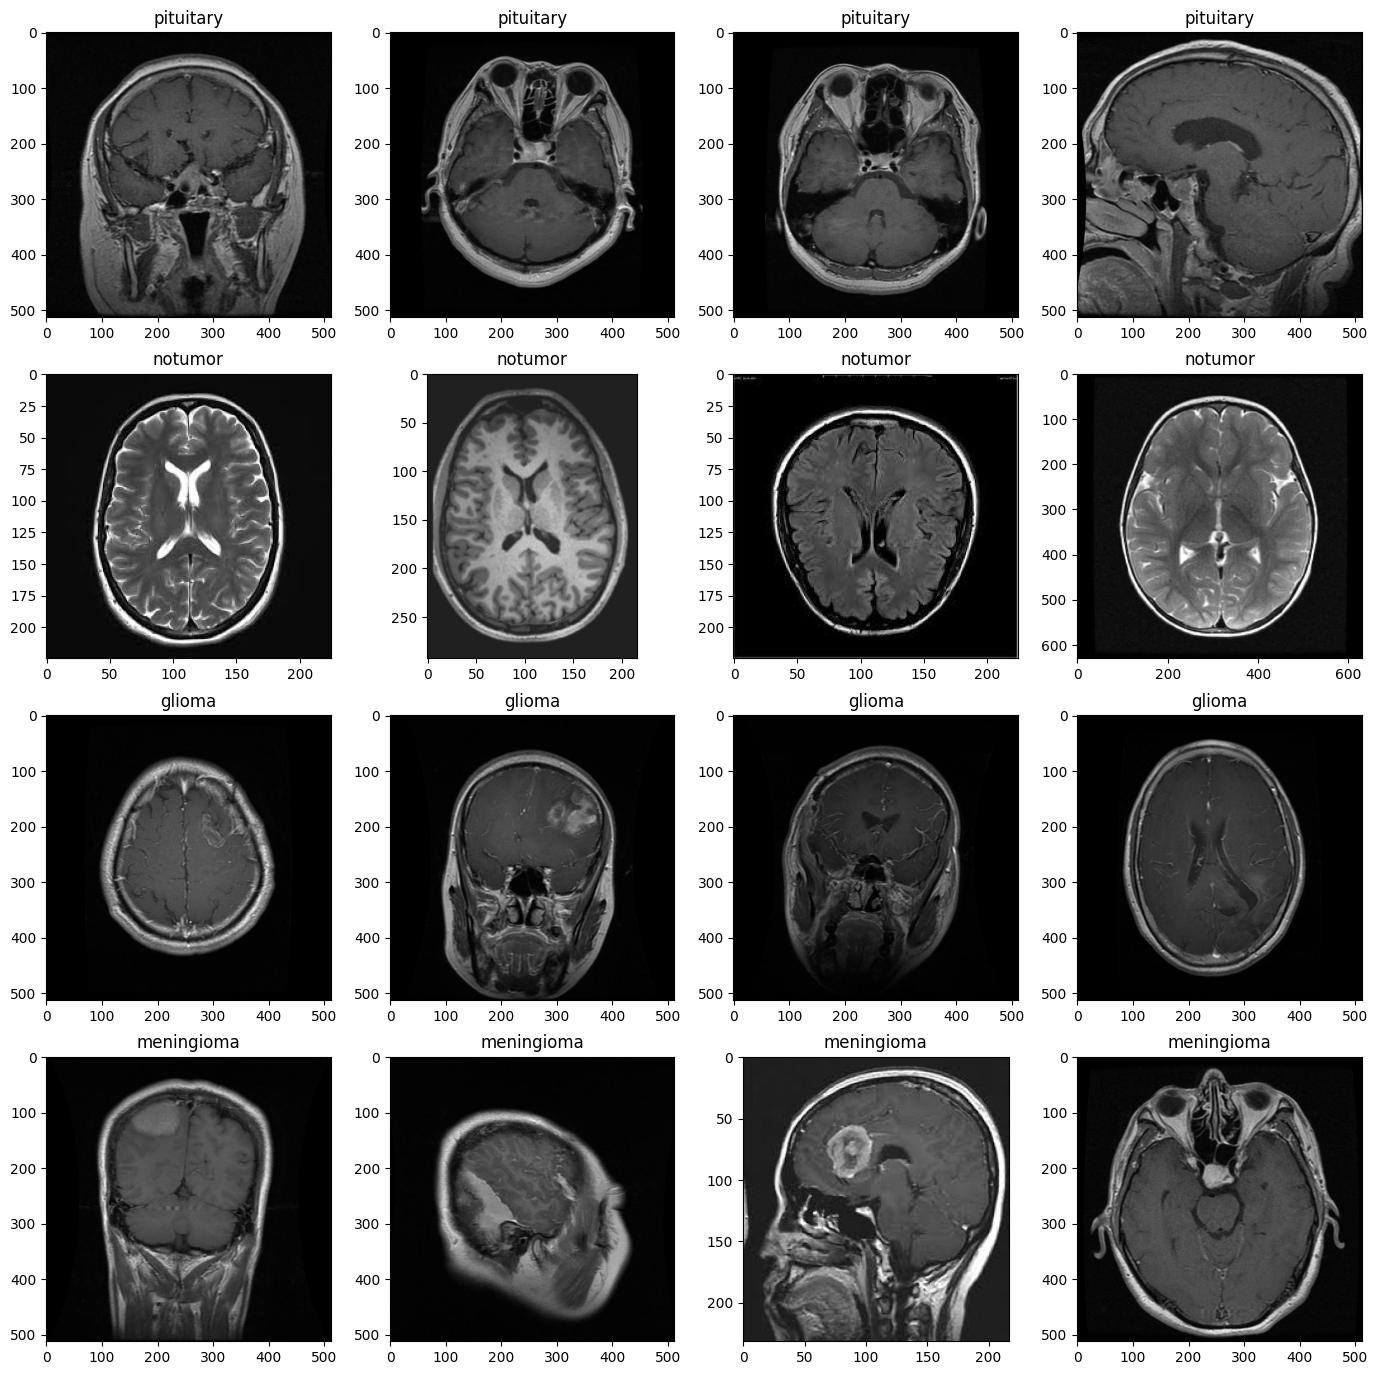

In [4]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize = (17, 17))

index = 0

for c in classes:
  random.shuffle(filepath_dict[c])
  path_list = filepath_dict[c][:5]

  for i in range(1, 5):
    index +=1
    plt.subplot(4, 4,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [5]:
IMG_SIZE = (224, 224)  # Image size required for ResNet50
BATCH_SIZE = 32  # Number of images processed at once
EPOCHS = 50  # Number of training cycles


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/Training"
valid_dir = "/content/Testing"

# Data Augmentation for training (Prevents Overfitting)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale validation images
valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Use 'categorical' if multi-class
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
No_images_per_class = []
Class_name = []
for i in os.listdir("/content/Training"):
  train_class = os.listdir(os.path.join("/content/Training", i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print(f"Number of images in {i} : {len(train_class)}")

Number of images in notumor : 1595
Number of images in glioma : 1321
Number of images in pituitary : 1457
Number of images in meningioma : 1339


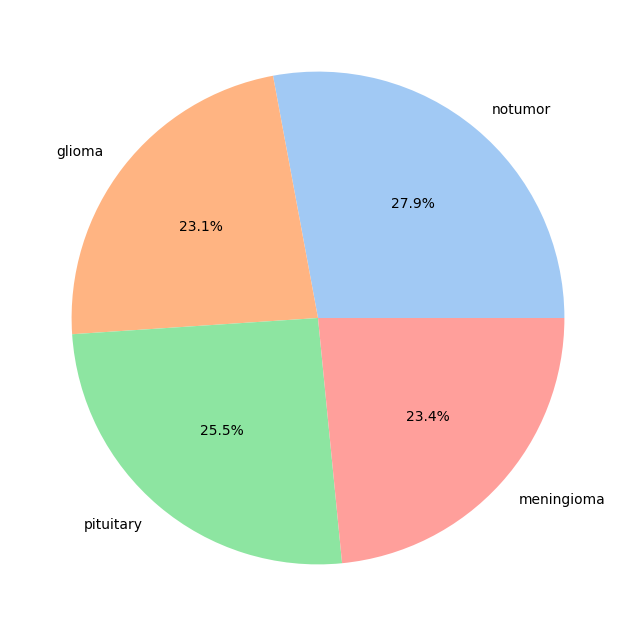

In [8]:
plt.figure(figsize =(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, labels = Class_name, autopct = "%1.1f%%", colors = colors)
plt.show()

In [9]:
def crop_image(image, plot=False):

  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
  img_thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY)[1]
  img_thresh = cv2.erode(img_thresh, None, iterations = 2)
  img_thresh = cv2.dilate(img_thresh, None, iterations = 2)

  contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  contours = imutils.grab_contours(contours)

  c = max(contours, key = cv2.contourArea)

  extLeft = tuple(c[c[:, :, 0].argmin()])[0]
  extRight = tuple(c[c[:, :, 0].argmax()])[0]
  extTop = tuple(c[c[:, :, 1].argmin()])[0]
  extBottom = tuple(c[c[:, :, 1].argmax()])[0]

  new_img = image[extTop[1]: extBottom[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(new_img)
    plt.title("Cropped Image")
    plt.show()
  return new_img


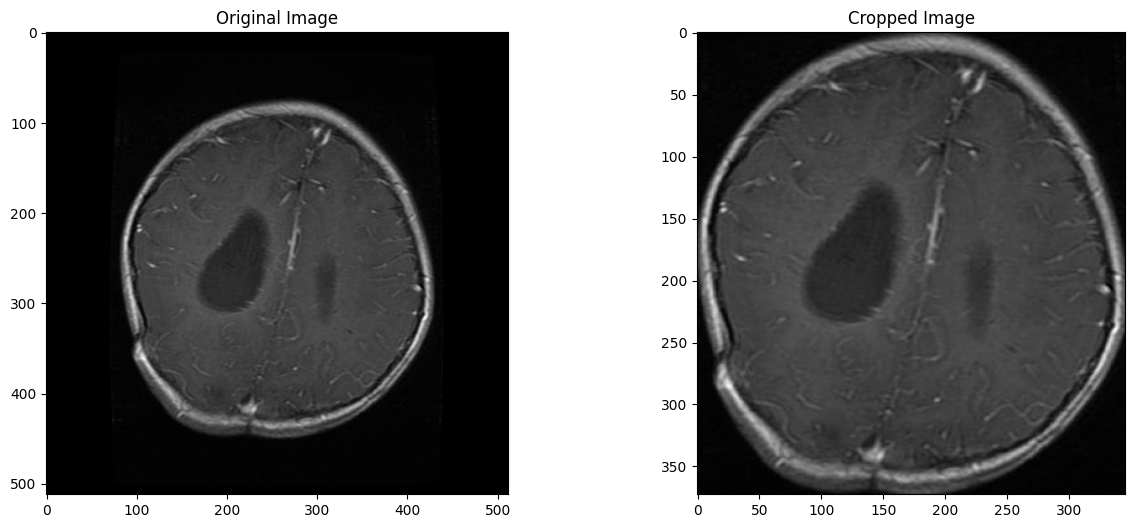

In [10]:
example_img = cv2.imread("/content/Testing/glioma/Te-gl_0018.jpg")
cropped_imgs = crop_image(example_img, plot=True)

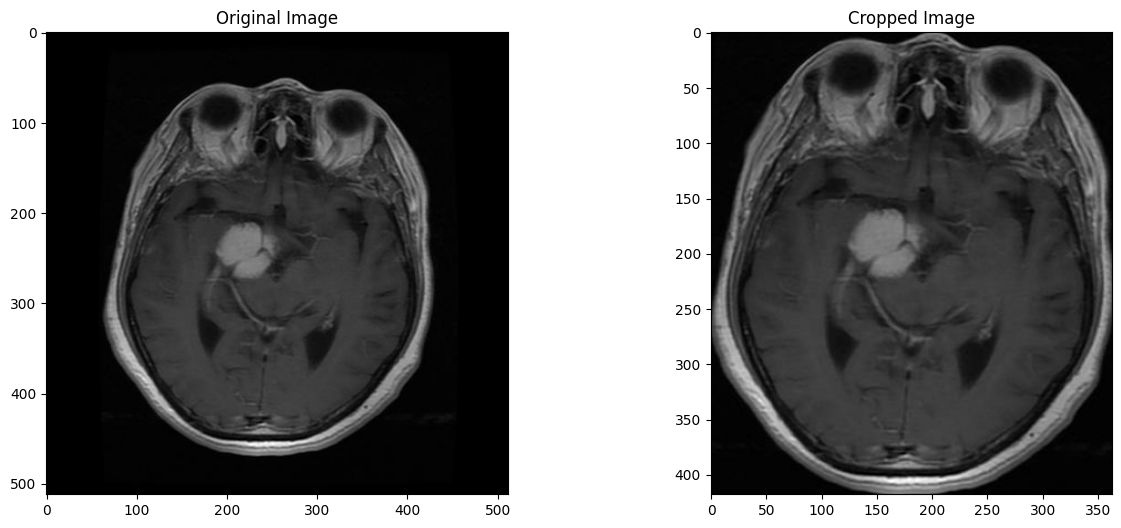

In [11]:
example_img = cv2.imread("/content/Training/meningioma/Tr-me_0061.jpg")
cropped_imgs = crop_image(example_img, plot=True)

Found 4000 images belonging to 4 classes.
Found 1712 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 758ms/step - accuracy: 0.5064 - loss: 4.1275 - val_accuracy: 0.2313 - val_loss: 19.4906
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 595ms/step - accuracy: 0.6265 - loss: 2.1712 - val_accuracy: 0.2377 - val_loss: 14.2742
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 591ms/step - accuracy: 0.6656 - loss: 2.0474 - val_accuracy: 0.4246 - val_loss: 3.7141
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 588ms/step - accuracy: 0.6680 - loss: 1.9536 - val_accuracy: 0.5940 - val_loss: 2.6020
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 588ms/step - accuracy: 0.7079 - loss: 1.8338 - val_accuracy: 0.6530 - val_loss: 2.0828
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step - accuracy: 0.7374 - loss: 1.7173 - val_accuracy: 0.7056 - val_loss: 2.1057
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 725ms/step - accuracy: 0.7419 - loss: 1.6499 - val_accuracy: 0.6887 - val_loss: 1.9703
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 654ms/step - accuracy: 0.7557 - loss

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.7848 - loss: 1.3132
Test Accuracy: 77.75%


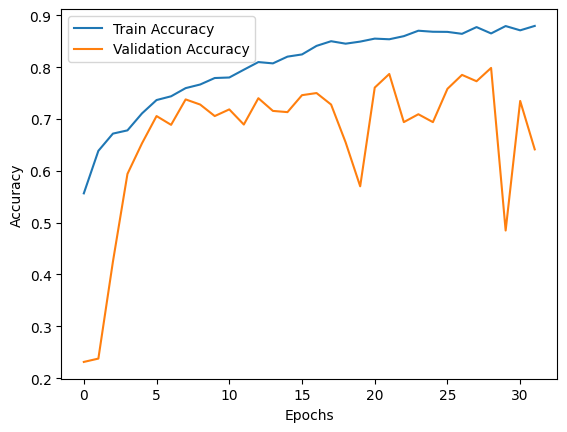

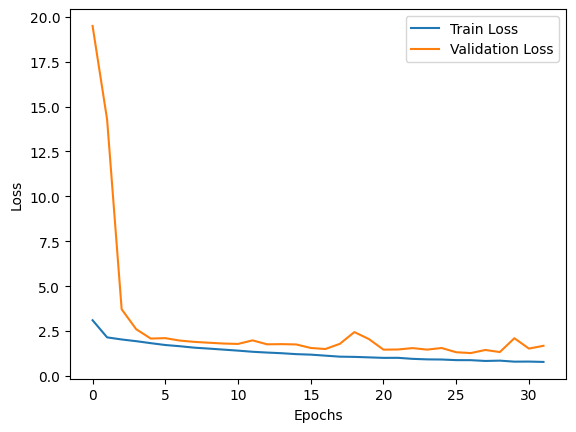

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Step 1: Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Split 30% for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/Training',  # Replace with your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify this as training data
)

validation_generator = train_datagen.flow_from_directory(
    '/content/Training',  # Replace with your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify this as validation data
)

# Step 2: Build the Model
model = Sequential()

# Add convolutional layers with batch normalization and L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers with dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

model.add(Dense(4, activation='softmax'))  # 4 classes (Change according to your dataset)

# Step 3: Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 4: Early Stopping Callback
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[earlystop]
)

# Step 6: Save the Model
model.save('Brain_tumor.h5')

# Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Step 8: Visualize Training and Validation Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Step 9: Visualize Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,429,902 (589.10 MB)

 Trainable params: 51,476,484 (196.37 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 102,952,970 (392.73 MB)

In [15]:

# Method 1: Display Training and Validation Accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Method 2: Display Test Accuracy
test_loss, test_accuracy = model.evaluate(validation_generator)  # Evaluate the model on the test set
print(f"Test Accuracy: {test_accuracy:.4f}")

# Method 3: Compute Classification Metrics
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Get true labels and predicted labels
y_true = validation_generator.classes  # True labels from the test set
y_pred = np.argmax(model.predict(validation_generator), axis=1)  # Predicted labels

# Display classification report
report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
print("Classification Report:")
print(report)

# Compute and display overall Precision, Recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")


Final Training Accuracy: 0.8795
Final Validation Accuracy: 0.6414
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 448ms/step - accuracy: 0.7934 - loss: 1.2511
Test Accuracy: 0.7810
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.23      0.20      0.21       396
  meningioma       0.26      0.29      0.28       401
     notumor       0.30      0.30      0.30       478
   pituitary       0.26      0.26      0.26       437

    accuracy                           0.27      1712
   macro avg       0.26      0.26      0.26      1712
weighted avg       0.26      0.27      0.26      1712

Overall Precision: 0.2641
Overall Recall: 0.2652
Overall F1-Score: 0.2642


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.26      0.22      0.24       396
    No Tumor       0.24      0.27      0.26       401
  Meningioma       0.30      0.31      0.30       478
   Pituitary       0.27      0.27      0.27       437

    accuracy                           0.27      1712
   macro avg       0.27      0.27      0.27      1712
weighted avg       0.27      0.27      0.27      1712


Macro Average Metrics:
Precision (Macro): 0.2671
Recall (Macro): 0.2666
F1 Score (Macro): 0.2663

Micro Average Metrics:
Precision (Micro): 0.2687
Recall (Micro): 0.2687
F1 Score (Micro): 0.2687

Matthews Correlation Coefficient (MCC): 0.0224

AUC-ROC (Macro Average): 0.5117


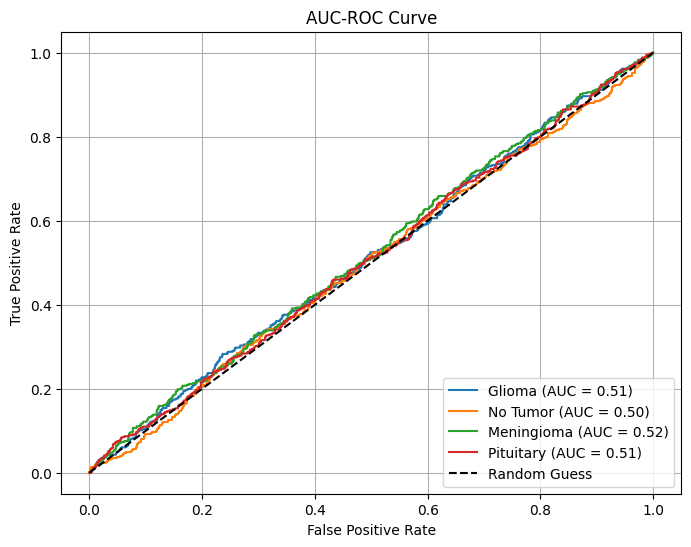

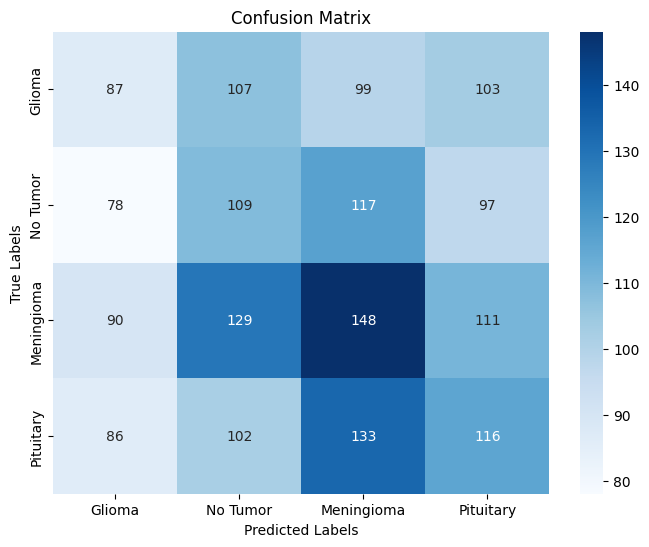

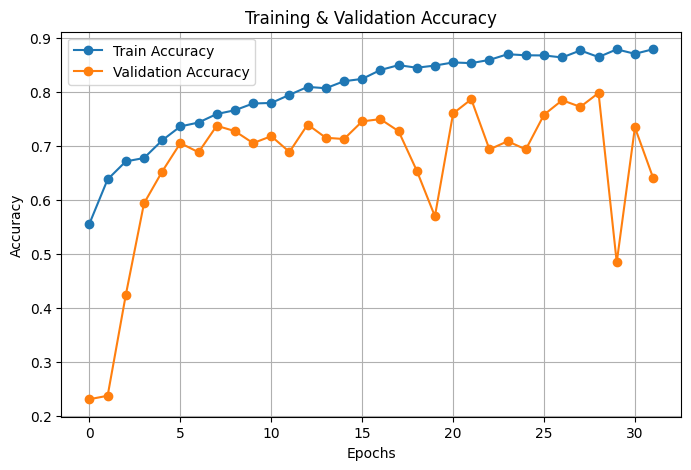

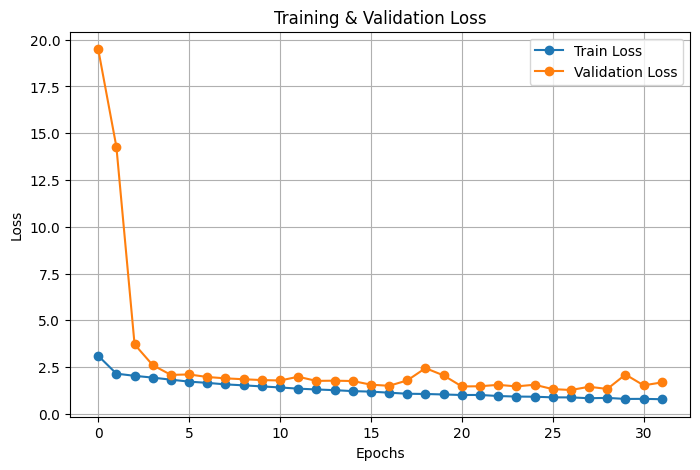


All performance metrics and graphs are displayed successfully and saved as JPG files!


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc

# Get true labels and predicted labels
y_true = validation_generator.classes  # True labels from validation data
y_pred_probs = model.predict(validation_generator)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Classification Report
class_labels = ["Glioma", "No Tumor", "Meningioma", "Pituitary"]  # Labels for brain tumor dataset
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

# Compute Precision, Recall, F1-score (Macro & Micro Average)
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")
f1_macro = f1_score(y_true, y_pred, average="macro")

precision_micro = precision_score(y_true, y_pred, average="micro")
recall_micro = recall_score(y_true, y_pred, average="micro")
f1_micro = f1_score(y_true, y_pred, average="micro")

print(f"\nMacro Average Metrics:")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")

print(f"\nMicro Average Metrics:")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")

# Compute MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_true, y_pred)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")

# Compute AUC-ROC Curve
y_true_one_hot = np.eye(len(class_labels))[y_true]  # Convert y_true to one-hot encoding
auc_roc_macro = roc_auc_score(y_true_one_hot, y_pred_probs, average="macro", multi_class="ovr")
print(f"\nAUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# Plot AUC-ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("auc_roc_curve.jpg", dpi=300)  # Save as JPG
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.jpg", dpi=300)  # Save as JPG
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("training_accuracy.jpg", dpi=300)  # Save as JPG
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("training_loss.jpg", dpi=300)  # Save as JPG
plt.show()

print("\nAll performance metrics and graphs are displayed successfully and saved as JPG files!")

54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 519ms/step


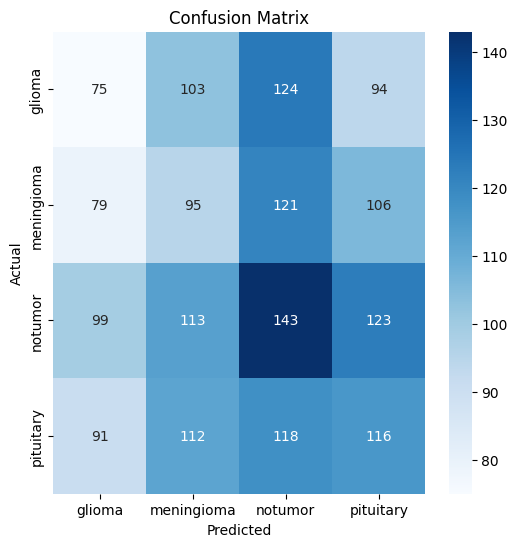

In [17]:
#Get True Labels
y_true = validation_generator.classes  # Get the actual class labels
y_pred = np.argmax(model.predict(validation_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)
#Plot the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
#  Display Training & Validation Accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

#Display Test Accuracy (Fixed)
test_loss, test_accuracy = model.evaluate(validation_generator)  # Fixed line
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display Classification Report (Fixed)
report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())  # Fixed variable name
print("Classification Report:")
print(report)


Final Training Accuracy: 0.8795
Final Validation Accuracy: 0.6414
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - accuracy: 0.7868 - loss: 1.2719
Test Accuracy: 0.7763
Classification Report:
              precision    recall  f1-score   support

      glioma       0.22      0.19      0.20       396
  meningioma       0.22      0.24      0.23       401
     notumor       0.28      0.30      0.29       478
   pituitary       0.26      0.27      0.26       437

    accuracy                           0.25      1712
   macro avg       0.25      0.25      0.25      1712
weighted avg       0.25      0.25      0.25      1712



Please enter the path to the image for prediction: /content/Training/glioma/Tr-glTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


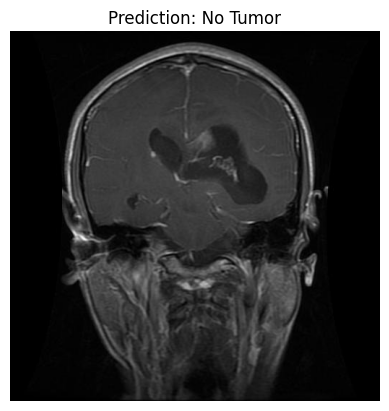

Prediction: No Tumor


In [22]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the image size that your model expects (use the same size as during training)
img_size = (224, 224)

# Load your model (Make sure to replace with the correct model path)
model = tf.keras.models.load_model("/content/Brain_tumor.h5")

# Class names (change to match your classes)
class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']

def predict_image(img_path):
    # Load the image from the path
    img = cv2.imread(img_path)
    original_img = img.copy()  # Save the original image for display
    img = cv2.resize(img, img_size)  # Resize to the model input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index

    # Display the image and prediction
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

    # Return the predicted class
    return class_names[predicted_class]

# Get the image path from the user
image_path = input("Please enter the path to the image for prediction: ")

# Ensure the image exists
if os.path.exists(image_path):
    prediction = predict_image(image_path)
    print(f"Prediction: {prediction}")
else:
    print("The image path is invalid. Please check the file path and try again.")


Please upload an MRI scan for prediction


Saving Tr-gl_0076.jpg to Tr-gl_0076 (1).jpg


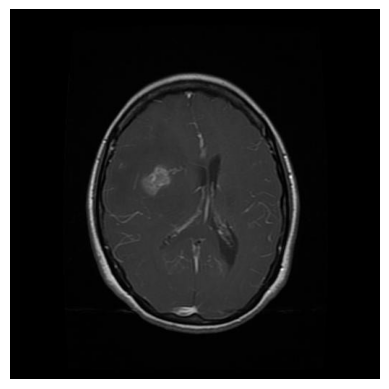

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Prediction: Glioma
Confidence: 100.00%


In [25]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/Brain_tumor.h5")  # Ensure model file is available
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels
class_labels = ["Glioma", "No Tumor", "Meningioma", "Pituitary"]

# Upload an image
print("Please upload an MRI scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")


Please upload an MRI scan for prediction


Saving Tr-pi_0161.jpg to Tr-pi_0161.jpg


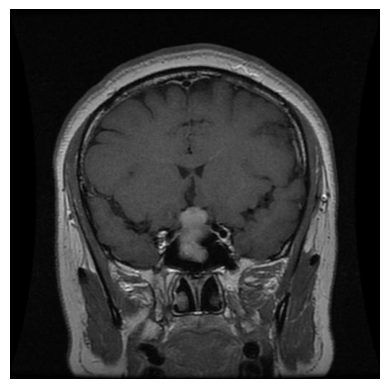

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Prediction: Pituitary
Confidence: 100.00%


In [26]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
def load_model():
    model = tf.keras.models.load_model("/content/Brain_tumor.h5")  # Ensure model file is available
    return model

model = load_model()

# Function to preprocess image
def preprocess_image(image):
    image = np.array(image)
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Define class labels
class_labels = ["Glioma", "No Tumor", "Meningioma", "Pituitary"]

# Upload an image
print("Please upload an MRI scan for prediction")
uploaded = files.upload()

for filename in uploaded.keys():
    image = Image.open(filename).convert("RGB")

    # Display the uploaded image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)
    class_idx = np.argmax(prediction)
    result = class_labels[class_idx]
    confidence = prediction[0][class_idx] * 100

    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")
